In [1]:
import arrow
import netrc
import pandas as pd
import pickle

from jira import JIRA
from os.path import exists

In [2]:
JIRA_DOMAIN = "gremlininc.atlassian.net"

class CustomField:
    def __init__(self, field_id, name, field_name=None):
        self.field_id = field_id
        self.field_key = f"customfield_{field_id}"
        self.name = name
        if field_name != None:
            self.field_name = field_name
        else:
            self.field_name = name.lower().replace(" ", "_")
        

CUSTOM_FIELDS = [
    CustomField(10081, "Work Category"),
    CustomField(10079, "Team Assigned"),
    CustomField(10025, "Story Points"),
]

# Authentication

See README.md in this folder for how to setup authentication

In [3]:
auth_file = netrc.netrc()
authTokens = auth_file.authenticators(JIRA_DOMAIN)

user_email = authTokens[0]
api_token = authTokens[2]

In [4]:
jira_url = f"https://{JIRA_DOMAIN}/"

# jira = JIRA(jira_url, basic_auth=(user_email, api_token))

# projects = jira.projects()  # Test Authentication

# Jira API Limits

Jira cloud limits issue searches to 100 results. We paginate over week long periods to collate all the issues from our desired
timeline.

In [5]:
def retrieve_issues():
    # start = arrow.get("2021-03-01")
    start = arrow.get("2022-03-01")
    end = arrow.utcnow()

    jql_template = """
    PROJECT = EN
    AND created >= {}
    AND created <= {}
    AND statusCategory = Done
    AND resolution = Done
    """

    result_list = []

    # If a result set has 99+ results, there's a good chance the API is limiting results and the date windows should be smaller.
    class LimitedResultsException(Exception):
        pass

    for r in arrow.Arrow.span_range('week', start, end):
        jql = jql_template.format(r[0].date(), r[1].date())
        results = jira.search_issues(jql, expand="changelog,renderedFields")

        if len(results) >= 99:
            raise LimitedResultsException()
        result_list.extend(results)

    return result_list

In [6]:
cache_key = arrow.utcnow().format("YYYY-MM-DD")
cache_file = f"results_{cache_key}.pickle"

if exists(cache_file):
    print(f"Reading cached results from {cache_file}")
    with open(cache_file, 'rb') as f:
        result_list = pickle.load(f)
else:
    print("Retrieving results from JIRA.")
    result_list = retrieve_issues()
    print(f"Writing results to {cache_file}")
    with open(cache_file, 'wb') as f:
        pickle.dump(result_list, f, pickle.HIGHEST_PROTOCOL)

Reading cached results from results_2022-05-07.pickle


In [7]:
class WorkflowTransitionDAO:
    def __init__(self, timestamp, history_item):
        self._history_item = history_item
        
        self.field = history_item.field
        self.fieldtype = history_item.fieldtype
        
        self.timestamp = arrow.get(timestamp)
        
        self.from_state_id = getattr(history_item, "from")
        self.to_state_id = history_item.to
        
        self.from_state = history_item.fromString
        self.to_state = history_item.toString
        
    def __str__(self):
        return f"[{self.timestamp.date()}] '{self.from_state}'({self.from_state_id}) -> '{self.to_state}'({self.to_state_id})"


class WorkflowTransitionHistory(list):
    def boo(self):
        return "boo"


def try_parse_int(s, val=None):
  try:
    return int(s)
  except TypeError:
    return val


        
class Issue:
    def __init__(self, issue):
        self._issue = issue
        self.key = issue.key
        self.project = issue.fields.project
        self.issuetype = issue.fields.issuetype
        self.assignee = issue.fields.assignee
        self.status = issue.fields.status
        self.summary = issue.fields.summary

        self.created_ts = issue.fields.created
        self.created_date = arrow.get(issue.fields.created).date()
        
        self.resolution_ts = issue.fields.resolutiondate
        self.resolution_date = arrow.get(issue.fields.resolutiondate).date()
        
        self._field_mappers = {
            "story_points": lambda x: try_parse_int(x),
            "team_assigned": lambda x: x.value if x is not None else "Unassigned",
            "work_category": lambda x: x.value if x is not None else "Unassigned",
        }
        
        for cf in CUSTOM_FIELDS:
            if cf.field_name in self._field_mappers:
                mapper = self._field_mappers[cf.field_name]
            else:
                mapper = lambda x: x

            setattr(self, cf.field_name, mapper(getattr(self._issue.fields, cf.field_key, None)))
        
        
    @property
    def state_transitions(self):
        history_items = WorkflowTransitionHistory()

        for h in self._issue.changelog.histories:
            for i in [x for x in h.items if x.field == 'status']:
                history_items.append(WorkflowTransitionDAO(h.created, i))
            # print(getattr(h, "created", None))
        
        return history_items
        
    def __str__(self):
        return f"[{self.key}]"
    
    def __repr__(self):
        return f"{self.key}"

In [8]:
issues = []

for r in result_list:
    issues.append(Issue(r))        

In [9]:
def calculate_lifecycle(issues):
    issue_props = [
        "project",
        "key",
        "summary",
        "story_points",
        "team_assigned",
        "issuetype",
        "work_category",
        "assignee",
        "status",
        "created_date",
        "created_ts",
        "resolution_date",
        "resolution_ts",
    ]

    data = {}
    
    for f in issue_props:
        data[f] = [getattr(x, f) for x in issues]

    return pd.DataFrame(data)
    
df = calculate_lifecycle(issues)

In [10]:
print(issues[110]._issue.fields.customfield_10025)

3.0


In [11]:
df

,project,key,summary,story_points,team_assigned,issuetype,work_category,assignee,status,created_date,created_ts,resolution_date,resolution_ts
0,EN,EN-2378,Legacy K8sBackend Attacks can't be retrieved,NaN,Unassigned,Bug,Bug / Defect,Sam Rossoff,Done,2022-03-03,2022-03-03T14:31:57.610-0800,2022-03-08,2022-03-08T10:46:03.997-0800
1,EN,EN-2374,Double Deleting a Team throws 5XX,NaN,Unassigned,Bug,Bug / Defect,None,Done,2022-03-03,2022-03-03T09:30:39.029-0800,2022-03-03,2022-03-03T09:30:52.246-0800
2,EN,EN-2367,SPIKE: Create a test for a Kubernetes cluster ...,3.0,Kintsugi,Task,Technical Investment,Cătălin Podariu,Done,2022-03-03,2022-03-03T08:40:04.215-0800,2022-04-22,2022-04-22T03:11:48.640-0700
3,EN,EN-2360,Research: Upgrade Ubuntu version for CI jobs (...,1.0,Chaos Crusaders,Story,Technical Investment,Brian Cook,Done,2022-03-02,2022-03-02T10:47:22.758-0800,2022-04-07,2022-04-07T13:55:00.594-0700
4,EN,EN-2358,Migrate text content to MUI Typography,NaN,Unassigned,Sub-task,Unassigned,Gabriel Ricard,Done,2022-03-02,2022-03-02T08:45:50.766-0800,2022-03-04,2022-03-04T10:07:15.913-0800
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,EN,EN-2751,provide a paginated endpoint on support api to...,NaN,Kintsugi,Sub-task,Unassigned,Phil Gebhardt,Done,2022-05-03,2022-05-03T15:19:21.645-0700,2022-05-04,2022-05-04T13:33:50.308-0700
117,EN,EN-2747,Update property name to match what backend is ...,1.0,Chaos Crusaders,Bug,Bug / Defect,Gabriel Ricard,Done,2022-05-03,2022-05-03T12:12:01.494-0700,2022-05-05,2022-05-05T09:23:45.055-0700
118,EN,EN-2737,Modest memory attack ends up crazy large,3.0,Chaos Crusaders,Bug,Bug / Defect,Brian Cook,Done,2022-05-02,2022-05-02T20:43:02.167-0700,2022-05-06,2022-05-06T12:48:31.144-0700
119,EN,EN-2736,Replace targetExpression with targetingStrategy,NaN,Kintsugi,Sub-task,Unassigned,None,Done,2022-05-02,2022-05-02T18:53:22.624-0700,2022-05-04,2022-05-04T13:34:06.337-0700


In [12]:
df["resolution_year_month"] = df["resolution_date"].astype('datetime64').dt.strftime("%Y-%m")
df["resolution_month"] = df["resolution_date"].astype('datetime64').dt.month
df["resolution_year"] = df["resolution_date"].astype('datetime64').dt.year
df["resolution_qtr"] = df["resolution_date"].astype('datetime64').dt.quarter
df["resolution_year_qtr"] = df["resolution_year"].map(str) + "Q" + df["resolution_qtr"].map(str)
df

,project,key,summary,story_points,team_assigned,issuetype,work_category,assignee,status,created_date,created_ts,resolution_date,resolution_ts,resolution_year_month,resolution_month,resolution_year,resolution_qtr,resolution_year_qtr
0,EN,EN-2378,Legacy K8sBackend Attacks can't be retrieved,NaN,Unassigned,Bug,Bug / Defect,Sam Rossoff,Done,2022-03-03,2022-03-03T14:31:57.610-0800,2022-03-08,2022-03-08T10:46:03.997-0800,2022-03,3,2022,1,2022Q1
1,EN,EN-2374,Double Deleting a Team throws 5XX,NaN,Unassigned,Bug,Bug / Defect,None,Done,2022-03-03,2022-03-03T09:30:39.029-0800,2022-03-03,2022-03-03T09:30:52.246-0800,2022-03,3,2022,1,2022Q1
2,EN,EN-2367,SPIKE: Create a test for a Kubernetes cluster ...,3.0,Kintsugi,Task,Technical Investment,Cătălin Podariu,Done,2022-03-03,2022-03-03T08:40:04.215-0800,2022-04-22,2022-04-22T03:11:48.640-0700,2022-04,4,2022,2,2022Q2
3,EN,EN-2360,Research: Upgrade Ubuntu version for CI jobs (...,1.0,Chaos Crusaders,Story,Technical Investment,Brian Cook,Done,2022-03-02,2022-03-02T10:47:22.758-0800,2022-04-07,2022-04-07T13:55:00.594-0700,2022-04,4,2022,2,2022Q2
4,EN,EN-2358,Migrate text content to MUI Typography,NaN,Unassigned,Sub-task,Unassigned,Gabriel Ricard,Done,2022-03-02,2022-03-02T08:45:50.766-0800,2022-03-04,2022-03-04T10:07:15.913-0800,2022-03,3,2022,1,2022Q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,EN,EN-2751,provide a paginated endpoint on support api to...,NaN,Kintsugi,Sub-task,Unassigned,Phil Gebhardt,Done,2022-05-03,2022-05-03T15:19:21.645-0700,2022-05-04,2022-05-04T13:33:50.308-0700,2022-05,5,2022,2,2022Q2
117,EN,EN-2747,Update property name to match what backend is ...,1.0,Chaos Crusaders,Bug,Bug / Defect,Gabriel Ricard,Done,2022-05-03,2022-05-03T12:12:01.494-0700,2022-05-05,2022-05-05T09:23:45.055-0700,2022-05,5,2022,2,2022Q2
118,EN,EN-2737,Modest memory attack ends up crazy large,3.0,Chaos Crusaders,Bug,Bug / Defect,Brian Cook,Done,2022-05-02,2022-05-02T20:43:02.167-0700,2022-05-06,2022-05-06T12:48:31.144-0700,2022-05,5,2022,2,2022Q2
119,EN,EN-2736,Replace targetExpression with targetingStrategy,NaN,Kintsugi,Sub-task,Unassigned,None,Done,2022-05-02,2022-05-02T18:53:22.624-0700,2022-05-04,2022-05-04T13:34:06.337-0700,2022-05,5,2022,2,2022Q2


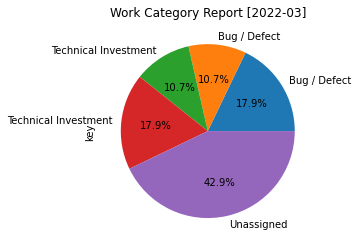

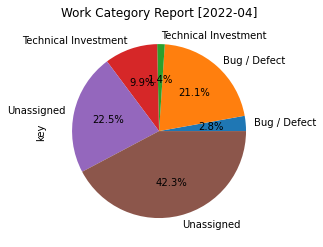

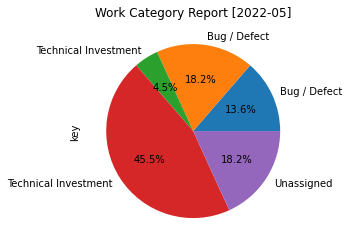

In [52]:
for m in df["resolution_year_month"].unique():
    df_tmp = df[~df["issuetype"].isin(["Sub-task", "Epic"])]
    
    plot_options = {
        "title": f"Work Category Report [{m}]",
        "legend": None,
        "autopct": "%1.1f%%",
        "labels": df_tmp["work_category"]
    }
    
    df_tmp[df_tmp["resolution_year_month"] == m].groupby(["resolution_year_month", "work_category"]).nunique().plot.pie(y="key", **plot_options)

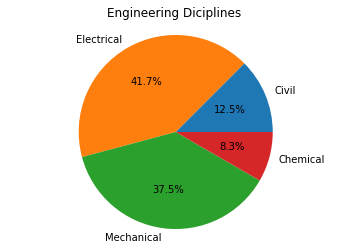

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# if using a Jupyter notebook, include:
%matplotlib inline

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ['Civil', 'Electrical', 'Mechanical', 'Chemical']
sizes = [15, 50, 45, 10]


fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Engineering Diciplines')


plt.show()